### Imports

In [393]:
import pandas as pd
import regex as re
from cleantext import clean
import pyarrow.feather as feather
from multiprocessing import Pool
import gc
import nltk
from nltk.util import ngrams
from nltk.corpus import words
import itertools
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import *
import time
from collections import Counter
import seaborn as sns

from sklearn.model_selection import train_test_split    # splitting the data 
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

In [394]:
def word_freq(dataframe):
    # get all words appearing in reliable articles
    reliable_words = [word for list in list(itertools.chain(dataframe.loc[dataframe['type'] == 'reliable'].content)) for word in list]
    # get all words appearing in fake articles
    fake_words = [word for list in list(itertools.chain(dataframe.loc[dataframe['type'] == 'fake'].content)) for word in list]
    # count words in both lists
    count_reliable = Counter(reliable_words)
    count_fake = Counter(fake_words)
    return pd.DataFrame({'reliable': pd.Series(count_reliable), 'fake': pd.Series(count_fake)})

### Loading the dataset

In [395]:
import pandas as pd
import regex as re
from cleantext import clean
data = pd.read_csv("data/sample_preprocessed_ver_2023-03-23-1679568060.csv", index_col=0)

In [396]:
# convert the strings to lists
pattern = re.compile(r"\w+")
def string_to_list(s):
    return pattern.findall(s)
data['content'] = data['content'].apply(string_to_list)

In [397]:
len(data)

3087

### Simple Model - Logistic Regression

In [398]:
X_train, X_val, y_train, y_val = train_test_split(data['content'], data['type'], test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=0)

In [399]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer=lambda x : x, max_features=200000)
vectorizer.fit(X_train)

CountVectorizer(analyzer=<function <lambda> at 0x2aa463640>,
                max_features=200000)

In [400]:
X_train.shape

(2469,)

In [401]:
vectorizer.get_feature_names_out()

array(['a', 'aa', 'aaa', ..., 'zyuganov', '️', '️num'], dtype=object)

In [402]:
X_train = vectorizer.transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

In [403]:
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [404]:
pred = logreg.predict(X_val)

In [405]:
accuracy_score(y_val, pred)

0.7281553398058253

In [406]:
from sklearn.metrics import f1_score

# y_val er pandas series, så omdanner også til ndarray
# positive = reliable
f1_score(pd.Series.to_numpy(y_val), pred, pos_label='reliable')

0.7123287671232876

[[121  33]
 [ 51 104]]


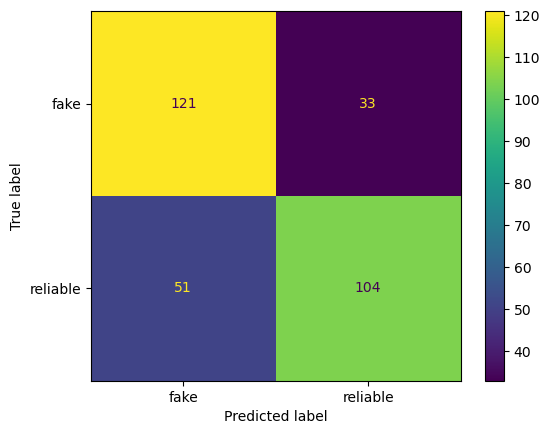

In [407]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# generating confusion matrix
cf_matrix = confusion_matrix(pd.Series.to_numpy(y_val), pred, labels=logreg.classes_)
print(cf_matrix)
# plotting to a heatmap
#sns.heatmap(cf_matrix, annot=True, fmt='g')
ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=logreg.classes_).plot()



### Advanced Model - Support Vector Machine

In [408]:
X_train, X_val, y_train, y_val = train_test_split(data['content'], data['type'], test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=0)

In [409]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer=lambda x : x, max_features=150000)
vectorizer.fit(X_train)

CountVectorizer(analyzer=<function <lambda> at 0x2aa688ca0>,
                max_features=150000)

In [410]:
X_train.shape

(2469,)

In [411]:
X_train = vectorizer.transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

In [412]:
vectorizer.get_feature_names_out()

array(['a', 'aa', 'aaa', ..., 'zyuganov', '️', '️num'], dtype=object)

In [413]:
from sklearn.linear_model import SGDClassifier
sdg_model = SGDClassifier(loss='hinge', penalty='l1', random_state=0, max_iter=5, tol=None)
sdg_model.fit(X_train, y_train)

SGDClassifier(max_iter=2, penalty='l1', random_state=0, tol=None)

In [414]:
pred = sdg_model.predict(X_val)

In [415]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, pred)

0.7119741100323624

In [416]:
from sklearn.metrics import f1_score
# y_val er pandas series, så omdanner også til ndarray
# positive = reliable
f1_score(pd.Series.to_numpy(y_val), pred, pos_label='reliable')

0.7174603174603175

[[107  47]
 [ 42 113]]


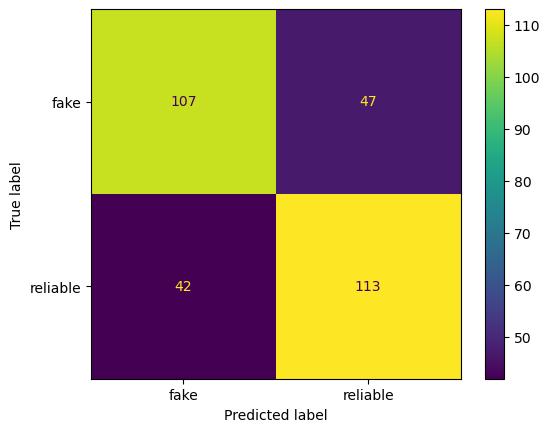

In [417]:
from sklearn.metrics import confusion_matrix
# generating confusion matrix
cf_matrix = confusion_matrix(pd.Series.to_numpy(y_val), pred)
print(cf_matrix)
# plotting to a heatmap
ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=sdg_model.classes_).plot()